In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader,random_split
import sys

In [2]:
#create dataset
print("downloading MNIST dataset if necessary")
data_dir='dataset'
train_dataset=torchvision.datasets.MNIST(data_dir,train=True,download=True)
test_dataset =torchvision.datasets.MNIST(data_dir,train=False,download=True)
transform=torchvision.transforms.Compose([
torchvision.transforms.ToTensor(),
])
train_dataset.transform=transform
test_dataset.transform=transform
m=len(train_dataset)
train_data,test_data=random_split(train_dataset,[int(m-m*0.1),int(m*0.1)])
torch.save(train_dataset,"train_dataset.pth")
torch.save(test_dataset,"test_dataset.pth")

downloading MNIST dataset if necessary


In [3]:
#create dataloader
batch_size=256
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
torch.save(train_loader,"train_loader.pth")
torch.save(test_loader,"test_loader.pth")

In [4]:
class Encoder(nn.Module):
    
    def __init__(self,encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn=nn.Sequential(
            nn.Conv2d(1,8,3,stride=2,padding=1),
            nn.ReLU(True),
            nn.Conv2d(8,16,3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16,32,3,stride=2,padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten=nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin=nn.Sequential(
            nn.Linear(3 * 3 * 32,128),
            nn.ReLU(True),
            nn.Linear(128,encoded_space_dim)
        )
        
    def forward(self,x):
        x=self.encoder_cnn(x)
        x=self.flatten(x)
        x=self.encoder_lin(x)
        return x

    
class Decoder(nn.Module):
    
    def __init__(self,encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin=nn.Sequential(
            nn.Linear(encoded_space_dim,128),
            nn.ReLU(True),
            nn.Linear(128,3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten=nn.Unflatten(dim=1,
        unflattened_size=(32,3,3))

        self.decoder_conv=nn.Sequential(
            nn.ConvTranspose2d(32,16,3,
            stride=2,output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,3,stride=2,
            padding=1,output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,1,3,stride=2,
            padding=1,output_padding=1)
        )
        
    def forward(self,x):
        x=self.decoder_lin(x)
        x=self.unflatten(x)
        x=self.decoder_conv(x)
        x=torch.sigmoid(x)
        return x

In [5]:
# Define all parameters
loss_fn=torch.nn.MSELoss()
torch.manual_seed(0)
d=4
encoder=Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder=Decoder(encoded_space_dim=d,fc2_input_dim=128)

lr= 0.001 #learning rate
params_to_optimize=[
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim=torch.optim.Adam(params_to_optimize,lr=lr,weight_decay=1e-05)

In [6]:
def add_noise(inputs,noise_factor=0.3):
     noisy=inputs+torch.randn_like(inputs)*noise_factor
     noisy=torch.clip(noisy,0.,1.)
     return noisy

In [7]:
### Training function
def train_epoch_den(encoder,decoder,dataloader,loss_fn,optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss=[]
    # Iterate the dataloader (we do not need the label values,this is unsupervised learning)
    for image_batch,_ in dataloader: # "_" ignore labels
        # Noise the data
        image_noisy=add_noise(image_batch,noise_factor)
        # Encode data
        encoded_data=encoder(image_noisy)
        # Decode data
        decoded_data=decoder(encoded_data)
        # Evaluate loss
        loss=loss_fn(decoded_data,image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().numpy())

    return np.mean(train_loss)

In [8]:
### Testing function
def test_epoch_den(encoder,decoder,dataloader,loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out=[]
        conc_label=[]
        for image_batch,_ in dataloader:
            # Noise the data
            image_noisy=add_noise(image_batch,noise_factor)
            # Encode data
            encoded_data=encoder(image_noisy)
            # Decode data
            decoded_data=decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data
            conc_label.append(image_batch
        # Create a single tensor with all the values in the lists
        conc_out=torch.cat(conc_out)
        conc_label=torch.cat(conc_label) 
        # Evaluate global loss
        test_loss=loss_fn(conc_out,conc_label)
    return test_loss.data

In [12]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets=test_dataset.targets.numpy()
    t_idx={i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax=plt.subplot(3,n,i+1)
      img=test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy=add_noise(img,noise_factor)     

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img =decoder(encoder(image_noisy))

      plt.imshow(img.squeeze().numpy(),cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax=plt.subplot(3,n,i + 1 + n)
      plt.imshow(image_noisy.squeeze().numpy(),cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax=plt.subplot(3,n,i + 1 + n + n)
      plt.imshow(rec_img.squeeze().numpy(),cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.7,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)     
    plt.show()   

EPOCH 1/31
	 partial train loss (single batch): 0.041801
	 partial train loss (single batch): 0.040306
	 partial train loss (single batch): 0.042423
	 partial train loss (single batch): 0.042716
	 partial train loss (single batch): 0.044603
	 partial train loss (single batch): 0.045014
	 partial train loss (single batch): 0.041197
	 partial train loss (single batch): 0.043670
	 partial train loss (single batch): 0.043301
	 partial train loss (single batch): 0.041185
	 partial train loss (single batch): 0.043322
	 partial train loss (single batch): 0.042208
	 partial train loss (single batch): 0.038552
	 partial train loss (single batch): 0.040490
	 partial train loss (single batch): 0.044231
	 partial train loss (single batch): 0.041347
	 partial train loss (single batch): 0.041219
	 partial train loss (single batch): 0.041928
	 partial train loss (single batch): 0.047496
	 partial train loss (single batch): 0.041789
	 partial train loss (single batch): 0.043305
	 partial train loss (s

	 partial train loss (single batch): 0.037541
	 partial train loss (single batch): 0.036539
	 partial train loss (single batch): 0.038144
	 partial train loss (single batch): 0.038613
	 partial train loss (single batch): 0.035619
	 partial train loss (single batch): 0.037056
	 partial train loss (single batch): 0.039390
	 partial train loss (single batch): 0.038785
	 partial train loss (single batch): 0.036761
	 partial train loss (single batch): 0.039013
	 partial train loss (single batch): 0.038561
	 partial train loss (single batch): 0.037251
	 partial train loss (single batch): 0.038302
	 partial train loss (single batch): 0.037206
	 partial train loss (single batch): 0.039026
	 partial train loss (single batch): 0.037277
	 partial train loss (single batch): 0.035164
	 partial train loss (single batch): 0.036590
	 partial train loss (single batch): 0.036851
	 partial train loss (single batch): 0.037099
	 partial train loss (single batch): 0.035302
	 partial train loss (single batch

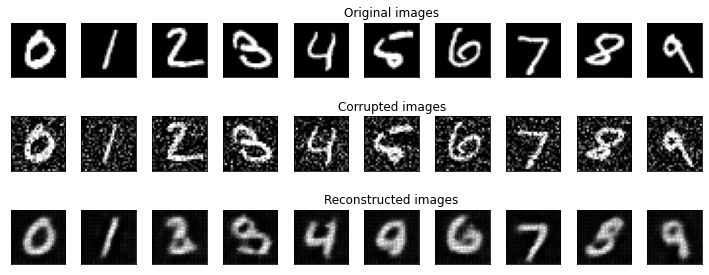

EPOCH 2/31
	 partial train loss (single batch): 0.033884
	 partial train loss (single batch): 0.033026
	 partial train loss (single batch): 0.035192
	 partial train loss (single batch): 0.035086
	 partial train loss (single batch): 0.038528
	 partial train loss (single batch): 0.036893
	 partial train loss (single batch): 0.034462
	 partial train loss (single batch): 0.035241
	 partial train loss (single batch): 0.035414
	 partial train loss (single batch): 0.033790
	 partial train loss (single batch): 0.036025
	 partial train loss (single batch): 0.035027
	 partial train loss (single batch): 0.031751
	 partial train loss (single batch): 0.033333
	 partial train loss (single batch): 0.037198
	 partial train loss (single batch): 0.033889
	 partial train loss (single batch): 0.033768
	 partial train loss (single batch): 0.034414
	 partial train loss (single batch): 0.039877
	 partial train loss (single batch): 0.034069
	 partial train loss (single batch): 0.035799
	 partial train loss (s

	 partial train loss (single batch): 0.035353
	 partial train loss (single batch): 0.033940
	 partial train loss (single batch): 0.034889
	 partial train loss (single batch): 0.035417
	 partial train loss (single batch): 0.032169
	 partial train loss (single batch): 0.033812
	 partial train loss (single batch): 0.036196
	 partial train loss (single batch): 0.035510
	 partial train loss (single batch): 0.033310
	 partial train loss (single batch): 0.035036
	 partial train loss (single batch): 0.035234
	 partial train loss (single batch): 0.034252
	 partial train loss (single batch): 0.036255
	 partial train loss (single batch): 0.034139
	 partial train loss (single batch): 0.036235
	 partial train loss (single batch): 0.034026
	 partial train loss (single batch): 0.032155
	 partial train loss (single batch): 0.034132
	 partial train loss (single batch): 0.033783
	 partial train loss (single batch): 0.034187
	 partial train loss (single batch): 0.032075
	 partial train loss (single batch

	 partial train loss (single batch): 0.032086
	 partial train loss (single batch): 0.032518
	 partial train loss (single batch): 0.037026
	 partial train loss (single batch): 0.032621
	 partial train loss (single batch): 0.031686
	 partial train loss (single batch): 0.032004
	 partial train loss (single batch): 0.031833
	 partial train loss (single batch): 0.031605
	 partial train loss (single batch): 0.029352
	 partial train loss (single batch): 0.030448
	 partial train loss (single batch): 0.033704
	 partial train loss (single batch): 0.031846
	 partial train loss (single batch): 0.030890
	 partial train loss (single batch): 0.032330
	 partial train loss (single batch): 0.031214
	 partial train loss (single batch): 0.031409
	 partial train loss (single batch): 0.034381
	 partial train loss (single batch): 0.036316
	 partial train loss (single batch): 0.032972
	 partial train loss (single batch): 0.034528
	 partial train loss (single batch): 0.032880
	 partial train loss (single batch

	 partial train loss (single batch): 0.030704
	 partial train loss (single batch): 0.029266
	 partial train loss (single batch): 0.029636
	 partial train loss (single batch): 0.033014
	 partial train loss (single batch): 0.029622
	 partial train loss (single batch): 0.029675
	 partial train loss (single batch): 0.033592
	 partial train loss (single batch): 0.031994
	 partial train loss (single batch): 0.031812
	 partial train loss (single batch): 0.032338
	 partial train loss (single batch): 0.029496
	 partial train loss (single batch): 0.030346
	 partial train loss (single batch): 0.031210
	 partial train loss (single batch): 0.031419
	 partial train loss (single batch): 0.033615
	 partial train loss (single batch): 0.030148
	 partial train loss (single batch): 0.032198
	 partial train loss (single batch): 0.034569
	 partial train loss (single batch): 0.032010
	 partial train loss (single batch): 0.034578
	 partial train loss (single batch): 0.030573
	 partial train loss (single batch

	 partial train loss (single batch): 0.030442
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch): 0.028990
	 partial train loss (single batch): 0.032272
	 partial train loss (single batch): 0.029501
	 partial train loss (single batch): 0.028635
	 partial train loss (single batch): 0.028753
	 partial train loss (single batch): 0.034501
	 partial train loss (single batch): 0.029408
	 partial train loss (single batch): 0.031747
	 partial train loss (single batch): 0.031083
	 partial train loss (single batch): 0.029614
	 partial train loss (single batch): 0.031145
	 partial train loss (single batch): 0.030933
	 partial train loss (single batch): 0.027926
	 partial train loss (single batch): 0.031582
	 partial train loss (single batch): 0.030388
	 partial train loss (single batch): 0.033318
	 partial train loss (single batch): 0.029403
	 partial train loss (single batch): 0.031383
	 partial train loss (single batch): 0.031241
	 partial train loss (single batch

	 partial train loss (single batch): 0.033271
	 partial train loss (single batch): 0.030793
	 partial train loss (single batch): 0.029163
	 partial train loss (single batch): 0.031463
	 partial train loss (single batch): 0.030986
	 partial train loss (single batch): 0.032050
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.030006
	 partial train loss (single batch): 0.029246
	 partial train loss (single batch): 0.029048
	 partial train loss (single batch): 0.031188
	 partial train loss (single batch): 0.028837
	 partial train loss (single batch): 0.027642
	 partial train loss (single batch): 0.031830
	 partial train loss (single batch): 0.030990
	 partial train loss (single batch): 0.027759
	 partial train loss (single batch): 0.030181
	 partial train loss (single batch): 0.029885
	 partial train loss (single batch): 0.028942
	 partial train loss (single batch): 0.030336
	 partial train loss (single batch): 0.028958
	 partial train loss (single batch

	 partial train loss (single batch): 0.029707
	 partial train loss (single batch): 0.028843
	 partial train loss (single batch): 0.030000
	 partial train loss (single batch): 0.028839
	 partial train loss (single batch): 0.029023
	 partial train loss (single batch): 0.032637
	 partial train loss (single batch): 0.033535
	 partial train loss (single batch): 0.030872
	 partial train loss (single batch): 0.032494
	 partial train loss (single batch): 0.030824
	 partial train loss (single batch): 0.032936
	 partial train loss (single batch): 0.032953
	 partial train loss (single batch): 0.031320
	 partial train loss (single batch): 0.030075
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.029538
	 partial train loss (single batch): 0.029681
	 partial train loss (single batch): 0.028583
	 partial train loss (single batch): 0.029739
	 partial train loss (single batch): 0.030331
	 partial train loss (single batch): 0.031875
	 partial train loss (single batch

	 partial train loss (single batch): 0.027475
	 partial train loss (single batch): 0.028353
	 partial train loss (single batch): 0.029966
	 partial train loss (single batch): 0.030034
	 partial train loss (single batch): 0.032260
	 partial train loss (single batch): 0.028370
	 partial train loss (single batch): 0.030710
	 partial train loss (single batch): 0.032408
	 partial train loss (single batch): 0.030309
	 partial train loss (single batch): 0.032768
	 partial train loss (single batch): 0.028580
	 partial train loss (single batch): 0.029953
	 partial train loss (single batch): 0.029025
	 partial train loss (single batch): 0.030597
	 partial train loss (single batch): 0.031295
	 partial train loss (single batch): 0.027471
	 partial train loss (single batch): 0.029528
	 partial train loss (single batch): 0.031829
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.031586
	 partial train loss (single batch): 0.028946
	 partial train loss (single batch

	 partial train loss (single batch): 0.030055
	 partial train loss (single batch): 0.029637
	 partial train loss (single batch): 0.026383
	 partial train loss (single batch): 0.030493
	 partial train loss (single batch): 0.029232
	 partial train loss (single batch): 0.032410
	 partial train loss (single batch): 0.028263
	 partial train loss (single batch): 0.030009
	 partial train loss (single batch): 0.029790
	 partial train loss (single batch): 0.028537
	 partial train loss (single batch): 0.035558
	 partial train loss (single batch): 0.029188
	 partial train loss (single batch): 0.027851
	 partial train loss (single batch): 0.030470
	 partial train loss (single batch): 0.032249
	 partial train loss (single batch): 0.027607
	 partial train loss (single batch): 0.029915
	 partial train loss (single batch): 0.031830
	 partial train loss (single batch): 0.027206
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.028282
	 partial train loss (single batch

	 partial train loss (single batch): 0.029928
	 partial train loss (single batch): 0.027826
	 partial train loss (single batch): 0.026714
	 partial train loss (single batch): 0.030602
	 partial train loss (single batch): 0.029856
	 partial train loss (single batch): 0.026375
	 partial train loss (single batch): 0.028960
	 partial train loss (single batch): 0.028549
	 partial train loss (single batch): 0.027632
	 partial train loss (single batch): 0.028863
	 partial train loss (single batch): 0.028024
	 partial train loss (single batch): 0.029755
	 partial train loss (single batch): 0.027467
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.029740
	 partial train loss (single batch): 0.027577
	 partial train loss (single batch): 0.028489
	 partial train loss (single batch): 0.029372
	 partial train loss (single batch): 0.028130
	 partial train loss (single batch): 0.027508
	 partial train loss (single batch): 0.029437
	 partial train loss (single batch

	 partial train loss (single batch): 0.030128
	 partial train loss (single batch): 0.029199
	 partial train loss (single batch): 0.028950
	 partial train loss (single batch): 0.028336
	 partial train loss (single batch): 0.028573
	 partial train loss (single batch): 0.027454
	 partial train loss (single batch): 0.028905
	 partial train loss (single batch): 0.029495
	 partial train loss (single batch): 0.030768
	 partial train loss (single batch): 0.027859
	 partial train loss (single batch): 0.028539
	 partial train loss (single batch): 0.030185
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.028577
	 partial train loss (single batch): 0.031501
	 partial train loss (single batch): 0.028073
	 partial train loss (single batch): 0.028552
	 partial train loss (single batch): 0.028034
	 partial train loss (single batch): 0.029823
	 partial train loss (single batch): 0.031516
	 partial train loss (single batch): 0.028716
	 partial train loss (single batch

	 partial train loss (single batch): 0.029018
	 partial train loss (single batch): 0.028249
	 partial train loss (single batch): 0.029439
	 partial train loss (single batch): 0.030431
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.028409
	 partial train loss (single batch): 0.031040
	 partial train loss (single batch): 0.026536
	 partial train loss (single batch): 0.030575
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.028755
	 partial train loss (single batch): 0.028293
	 partial train loss (single batch): 0.026734
	 partial train loss (single batch): 0.029454
	 partial train loss (single batch): 0.030436
	 partial train loss (single batch): 0.029797
	 partial train loss (single batch): 0.032913
	 partial train loss (single batch): 0.028679
	 partial train loss (single batch): 0.029837
	 partial train loss (single batch): 0.028303
	 partial train loss (single batch): 0.031397
	 partial train loss (single batch

	 partial train loss (single batch): 0.035099
	 partial train loss (single batch): 0.028756
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.029616
	 partial train loss (single batch): 0.031322
	 partial train loss (single batch): 0.026502
	 partial train loss (single batch): 0.028976
	 partial train loss (single batch): 0.030842
	 partial train loss (single batch): 0.026471
	 partial train loss (single batch): 0.026335
	 partial train loss (single batch): 0.027617
	 partial train loss (single batch): 0.026446
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.027440
	 partial train loss (single batch): 0.026993
	 partial train loss (single batch): 0.029820
	 partial train loss (single batch): 0.031201
	 partial train loss (single batch): 0.029619
	 partial train loss (single batch): 0.028565
	 partial train loss (single batch): 0.027984
	 partial train loss (single batch): 0.029893
	 partial train loss (single batch

	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.026745
	 partial train loss (single batch): 0.029004
	 partial train loss (single batch): 0.026791
	 partial train loss (single batch): 0.027999
	 partial train loss (single batch): 0.028530
	 partial train loss (single batch): 0.027434
	 partial train loss (single batch): 0.026927
	 partial train loss (single batch): 0.028856
	 partial train loss (single batch): 0.027544
	 partial train loss (single batch): 0.028279
	 partial train loss (single batch): 0.028101
	 partial train loss (single batch): 0.025503
	 partial train loss (single batch): 0.029355
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.024158
	 partial train loss (single batch): 0.032774
	 partial train loss (single batch): 0.032503
	 partial train loss (single batch): 0.027582
	 partial train loss (single batch): 0.026641

 EPOCH 11/31 	 train loss 0.029 	 test loss 0.029


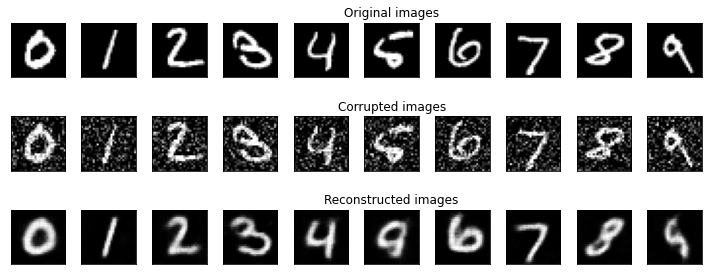

EPOCH 12/31
	 partial train loss (single batch): 0.026138
	 partial train loss (single batch): 0.026082
	 partial train loss (single batch): 0.028027
	 partial train loss (single batch): 0.026722
	 partial train loss (single batch): 0.032349
	 partial train loss (single batch): 0.029277
	 partial train loss (single batch): 0.026988
	 partial train loss (single batch): 0.027763
	 partial train loss (single batch): 0.027725
	 partial train loss (single batch): 0.026685
	 partial train loss (single batch): 0.028683
	 partial train loss (single batch): 0.028157
	 partial train loss (single batch): 0.025231
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.029629
	 partial train loss (single batch): 0.027610
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.031926
	 partial train loss (single batch): 0.027033
	 partial train loss (single batch): 0.029402
	 partial train loss (

	 partial train loss (single batch): 0.029448
	 partial train loss (single batch): 0.030296
	 partial train loss (single batch): 0.027242
	 partial train loss (single batch): 0.028314
	 partial train loss (single batch): 0.030316
	 partial train loss (single batch): 0.030250
	 partial train loss (single batch): 0.028474
	 partial train loss (single batch): 0.029624
	 partial train loss (single batch): 0.030180
	 partial train loss (single batch): 0.029570
	 partial train loss (single batch): 0.031677
	 partial train loss (single batch): 0.029434
	 partial train loss (single batch): 0.031527
	 partial train loss (single batch): 0.028463
	 partial train loss (single batch): 0.027724
	 partial train loss (single batch): 0.029881
	 partial train loss (single batch): 0.029161
	 partial train loss (single batch): 0.029794
	 partial train loss (single batch): 0.026750
	 partial train loss (single batch): 0.027936
	 partial train loss (single batch): 0.027413
	 partial train loss (single batch

	 partial train loss (single batch): 0.028057
	 partial train loss (single batch): 0.028135
	 partial train loss (single batch): 0.032813
	 partial train loss (single batch): 0.028695
	 partial train loss (single batch): 0.027515
	 partial train loss (single batch): 0.027795
	 partial train loss (single batch): 0.027834
	 partial train loss (single batch): 0.027358
	 partial train loss (single batch): 0.025236
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.029386
	 partial train loss (single batch): 0.028430
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.030787
	 partial train loss (single batch): 0.031264
	 partial train loss (single batch): 0.029196
	 partial train loss (single batch): 0.030482
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch

	 partial train loss (single batch): 0.030001
	 partial train loss (single batch): 0.030988
	 partial train loss (single batch): 0.027816
	 partial train loss (single batch): 0.025959
	 partial train loss (single batch): 0.025768
	 partial train loss (single batch): 0.030057
	 partial train loss (single batch): 0.026260
	 partial train loss (single batch): 0.025870
	 partial train loss (single batch): 0.029534
	 partial train loss (single batch): 0.028020
	 partial train loss (single batch): 0.028169
	 partial train loss (single batch): 0.028949
	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.027028
	 partial train loss (single batch): 0.028284
	 partial train loss (single batch): 0.028389
	 partial train loss (single batch): 0.030552
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.028829
	 partial train loss (single batch): 0.030667
	 partial train loss (single batch): 0.028901
	 partial train loss (single batch

	 partial train loss (single batch): 0.027966
	 partial train loss (single batch): 0.024595
	 partial train loss (single batch): 0.025901
	 partial train loss (single batch): 0.029323
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch): 0.025807
	 partial train loss (single batch): 0.025495
	 partial train loss (single batch): 0.031650
	 partial train loss (single batch): 0.026783
	 partial train loss (single batch): 0.028694
	 partial train loss (single batch): 0.028004
	 partial train loss (single batch): 0.027209
	 partial train loss (single batch): 0.028938
	 partial train loss (single batch): 0.028101
	 partial train loss (single batch): 0.025126
	 partial train loss (single batch): 0.029186
	 partial train loss (single batch): 0.027964
	 partial train loss (single batch): 0.030916
	 partial train loss (single batch): 0.026881
	 partial train loss (single batch): 0.028439
	 partial train loss (single batch): 0.028039
	 partial train loss (single batch

	 partial train loss (single batch): 0.030774
	 partial train loss (single batch): 0.028319
	 partial train loss (single batch): 0.027098
	 partial train loss (single batch): 0.029484
	 partial train loss (single batch): 0.029084
	 partial train loss (single batch): 0.029862
	 partial train loss (single batch): 0.026125
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.026905
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.026827
	 partial train loss (single batch): 0.025471
	 partial train loss (single batch): 0.029680
	 partial train loss (single batch): 0.028458
	 partial train loss (single batch): 0.025107
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.027073
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch): 0.027553
	 partial train loss (single batch): 0.026989
	 partial train loss (single batch

	 partial train loss (single batch): 0.027872
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.026170
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.030205
	 partial train loss (single batch): 0.030713
	 partial train loss (single batch): 0.028677
	 partial train loss (single batch): 0.030161
	 partial train loss (single batch): 0.028416
	 partial train loss (single batch): 0.030641
	 partial train loss (single batch): 0.030239
	 partial train loss (single batch): 0.028442
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch): 0.027872
	 partial train loss (single batch): 0.027116
	 partial train loss (single batch): 0.027011
	 partial train loss (single batch): 0.026039
	 partial train loss (single batch): 0.028204
	 partial train loss (single batch): 0.028486
	 partial train loss (single batch): 0.029520
	 partial train loss (single batch

	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.028491
	 partial train loss (single batch): 0.025212
	 partial train loss (single batch): 0.026451
	 partial train loss (single batch): 0.027990
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.029749
	 partial train loss (single batch): 0.026295
	 partial train loss (single batch): 0.028291
	 partial train loss (single batch): 0.030210
	 partial train loss (single batch): 0.028574
	 partial train loss (single batch): 0.030927
	 partial train loss (single batch): 0.026808
	 partial train loss (single batch): 0.027803
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.028779
	 partial train loss (single batch): 0.029361
	 partial train loss (single batch): 0.025852
	 partial train loss (single batch): 0.027488
	 partial train loss (single batch): 0.029564
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch

	 partial train loss (single batch): 0.028388
	 partial train loss (single batch): 0.027627
	 partial train loss (single batch): 0.026846
	 partial train loss (single batch): 0.028754
	 partial train loss (single batch): 0.027639
	 partial train loss (single batch): 0.024925
	 partial train loss (single batch): 0.029121
	 partial train loss (single batch): 0.027833
	 partial train loss (single batch): 0.030532
	 partial train loss (single batch): 0.026467
	 partial train loss (single batch): 0.028056
	 partial train loss (single batch): 0.027644
	 partial train loss (single batch): 0.027452
	 partial train loss (single batch): 0.034059
	 partial train loss (single batch): 0.027799
	 partial train loss (single batch): 0.026332
	 partial train loss (single batch): 0.028321
	 partial train loss (single batch): 0.030053
	 partial train loss (single batch): 0.025174
	 partial train loss (single batch): 0.028110
	 partial train loss (single batch): 0.029729
	 partial train loss (single batch

	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.027183
	 partial train loss (single batch): 0.026403
	 partial train loss (single batch): 0.028335
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch): 0.025091
	 partial train loss (single batch): 0.029360
	 partial train loss (single batch): 0.028460
	 partial train loss (single batch): 0.024968
	 partial train loss (single batch): 0.027286
	 partial train loss (single batch): 0.026767
	 partial train loss (single batch): 0.026114
	 partial train loss (single batch): 0.027288
	 partial train loss (single batch): 0.026691
	 partial train loss (single batch): 0.028222
	 partial train loss (single batch): 0.026044
	 partial train loss (single batch): 0.026085
	 partial train loss (single batch): 0.028145
	 partial train loss (single batch): 0.025965
	 partial train loss (single batch): 0.027096
	 partial train loss (single batch): 0.027940
	 partial train loss (single batch

	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.029922
	 partial train loss (single batch): 0.027882
	 partial train loss (single batch): 0.030108
	 partial train loss (single batch): 0.030173
	 partial train loss (single batch): 0.028092
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.027479
	 partial train loss (single batch): 0.026837
	 partial train loss (single batch): 0.026420
	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.027904
	 partial train loss (single batch): 0.028018
	 partial train loss (single batch): 0.029465
	 partial train loss (single batch): 0.026679
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.028531
	 partial train loss (single batch): 0.025349
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.029856
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch

	 partial train loss (single batch): 0.027900
	 partial train loss (single batch): 0.030551
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch): 0.026854
	 partial train loss (single batch): 0.026369
	 partial train loss (single batch): 0.028467
	 partial train loss (single batch): 0.028939
	 partial train loss (single batch): 0.025193
	 partial train loss (single batch): 0.026865
	 partial train loss (single batch): 0.029105
	 partial train loss (single batch): 0.025172
	 partial train loss (single batch): 0.028675
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.027030
	 partial train loss (single batch): 0.024898
	 partial train loss (single batch): 0.027403
	 partial train loss (single batch): 0.029071
	 partial train loss (single batch): 0.027969
	 partial train loss (single batch): 0.031115
	 partial train loss (single batch): 0.027352
	 partial train loss (single batch

	 partial train loss (single batch): 0.027306
	 partial train loss (single batch): 0.027474
	 partial train loss (single batch): 0.034072
	 partial train loss (single batch): 0.027544
	 partial train loss (single batch): 0.026033
	 partial train loss (single batch): 0.028109
	 partial train loss (single batch): 0.029736
	 partial train loss (single batch): 0.025200
	 partial train loss (single batch): 0.028125
	 partial train loss (single batch): 0.029100
	 partial train loss (single batch): 0.025315
	 partial train loss (single batch): 0.025270
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.025152
	 partial train loss (single batch): 0.026066
	 partial train loss (single batch): 0.026328
	 partial train loss (single batch): 0.025416
	 partial train loss (single batch): 0.028296
	 partial train loss (single batch): 0.029740
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.026925
	 partial train loss (single batch

	 partial train loss (single batch): 0.026600
	 partial train loss (single batch): 0.025945
	 partial train loss (single batch): 0.027163
	 partial train loss (single batch): 0.026305
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.025899
	 partial train loss (single batch): 0.025617
	 partial train loss (single batch): 0.027989
	 partial train loss (single batch): 0.025732
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.027578
	 partial train loss (single batch): 0.026639
	 partial train loss (single batch): 0.025936
	 partial train loss (single batch): 0.027593
	 partial train loss (single batch): 0.026353
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.026570
	 partial train loss (single batch): 0.023941
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.025273
	 partial train loss (single batch): 0.022906
	 partial train loss (single batch

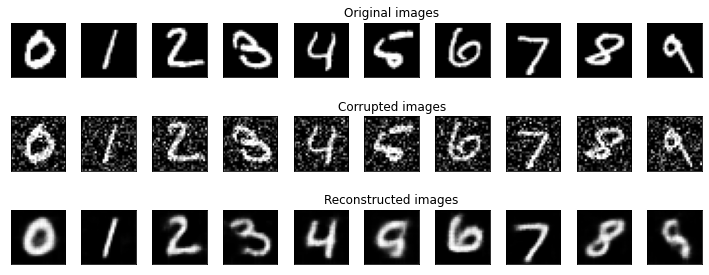

EPOCH 22/31
	 partial train loss (single batch): 0.024812
	 partial train loss (single batch): 0.025144
	 partial train loss (single batch): 0.026852
	 partial train loss (single batch): 0.025386
	 partial train loss (single batch): 0.030871
	 partial train loss (single batch): 0.028265
	 partial train loss (single batch): 0.025709
	 partial train loss (single batch): 0.026407
	 partial train loss (single batch): 0.026360
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.027499
	 partial train loss (single batch): 0.026719
	 partial train loss (single batch): 0.023846
	 partial train loss (single batch): 0.025194
	 partial train loss (single batch): 0.028589
	 partial train loss (single batch): 0.026620
	 partial train loss (single batch): 0.025243
	 partial train loss (single batch): 0.024489
	 partial train loss (single batch): 0.030679
	 partial train loss (single batch): 0.025902
	 partial train loss (single batch): 0.027851
	 partial train loss (

	 partial train loss (single batch): 0.028171
	 partial train loss (single batch): 0.028474
	 partial train loss (single batch): 0.028856
	 partial train loss (single batch): 0.026248
	 partial train loss (single batch): 0.027580
	 partial train loss (single batch): 0.028794
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.027793
	 partial train loss (single batch): 0.028942
	 partial train loss (single batch): 0.028968
	 partial train loss (single batch): 0.028371
	 partial train loss (single batch): 0.030854
	 partial train loss (single batch): 0.028276
	 partial train loss (single batch): 0.030275
	 partial train loss (single batch): 0.027536
	 partial train loss (single batch): 0.026877
	 partial train loss (single batch): 0.029104
	 partial train loss (single batch): 0.028277
	 partial train loss (single batch): 0.028808
	 partial train loss (single batch): 0.025703
	 partial train loss (single batch): 0.026757
	 partial train loss (single batch

	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.029079
	 partial train loss (single batch): 0.027148
	 partial train loss (single batch): 0.027131
	 partial train loss (single batch): 0.031784
	 partial train loss (single batch): 0.027173
	 partial train loss (single batch): 0.026215
	 partial train loss (single batch): 0.026432
	 partial train loss (single batch): 0.026620
	 partial train loss (single batch): 0.026190
	 partial train loss (single batch): 0.024281
	 partial train loss (single batch): 0.024967
	 partial train loss (single batch): 0.028733
	 partial train loss (single batch): 0.027478
	 partial train loss (single batch): 0.026043
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.025537
	 partial train loss (single batch): 0.025649
	 partial train loss (single batch): 0.029247
	 partial train loss (single batch): 0.030134
	 partial train loss (single batch): 0.028181
	 partial train loss (single batch

	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.029611
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch): 0.024998
	 partial train loss (single batch): 0.024977
	 partial train loss (single batch): 0.028988
	 partial train loss (single batch): 0.025134
	 partial train loss (single batch): 0.024395
	 partial train loss (single batch): 0.028695
	 partial train loss (single batch): 0.027117
	 partial train loss (single batch): 0.026876
	 partial train loss (single batch): 0.027824
	 partial train loss (single batch): 0.024510
	 partial train loss (single batch): 0.026140
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.026452
	 partial train loss (single batch): 0.028832
	 partial train loss (single batch): 0.025383
	 partial train loss (single batch): 0.027660
	 partial train loss (single batch): 0.029842
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch

	 partial train loss (single batch): 0.025245
	 partial train loss (single batch): 0.027065
	 partial train loss (single batch): 0.026785
	 partial train loss (single batch): 0.023862
	 partial train loss (single batch): 0.024941
	 partial train loss (single batch): 0.028188
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.025007
	 partial train loss (single batch): 0.024315
	 partial train loss (single batch): 0.030594
	 partial train loss (single batch): 0.025961
	 partial train loss (single batch): 0.027721
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.026522
	 partial train loss (single batch): 0.028390
	 partial train loss (single batch): 0.027067
	 partial train loss (single batch): 0.024562
	 partial train loss (single batch): 0.028550
	 partial train loss (single batch): 0.027380
	 partial train loss (single batch): 0.030258
	 partial train loss (single batch): 0.025894
	 partial train loss (single batch

	 partial train loss (single batch): 0.028612
	 partial train loss (single batch): 0.027946
	 partial train loss (single batch): 0.030750
	 partial train loss (single batch): 0.028008
	 partial train loss (single batch): 0.030343
	 partial train loss (single batch): 0.027188
	 partial train loss (single batch): 0.026684
	 partial train loss (single batch): 0.028965
	 partial train loss (single batch): 0.027992
	 partial train loss (single batch): 0.028462
	 partial train loss (single batch): 0.025404
	 partial train loss (single batch): 0.026458
	 partial train loss (single batch): 0.026253
	 partial train loss (single batch): 0.025751
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.026052
	 partial train loss (single batch): 0.024236
	 partial train loss (single batch): 0.028886
	 partial train loss (single batch): 0.027515
	 partial train loss (single batch): 0.023993
	 partial train loss (single batch): 0.026872
	 partial train loss (single batch

	 partial train loss (single batch): 0.028361
	 partial train loss (single batch): 0.027219
	 partial train loss (single batch): 0.025803
	 partial train loss (single batch): 0.026215
	 partial train loss (single batch): 0.025364
	 partial train loss (single batch): 0.025426
	 partial train loss (single batch): 0.029137
	 partial train loss (single batch): 0.029685
	 partial train loss (single batch): 0.027974
	 partial train loss (single batch): 0.029432
	 partial train loss (single batch): 0.027187
	 partial train loss (single batch): 0.029822
	 partial train loss (single batch): 0.029509
	 partial train loss (single batch): 0.027354
	 partial train loss (single batch): 0.026977
	 partial train loss (single batch): 0.026957
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.025856
	 partial train loss (single batch): 0.025292
	 partial train loss (single batch): 0.027183
	 partial train loss (single batch): 0.027150
	 partial train loss (single batch

	 partial train loss (single batch): 0.027045
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.027578
	 partial train loss (single batch): 0.024687
	 partial train loss (single batch): 0.026066
	 partial train loss (single batch): 0.026685
	 partial train loss (single batch): 0.026418
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.025288
	 partial train loss (single batch): 0.027234
	 partial train loss (single batch): 0.029535
	 partial train loss (single batch): 0.027415
	 partial train loss (single batch): 0.030391
	 partial train loss (single batch): 0.026098
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.026066
	 partial train loss (single batch): 0.027928
	 partial train loss (single batch): 0.028364
	 partial train loss (single batch): 0.024731
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.028463
	 partial train loss (single batch

	 partial train loss (single batch): 0.025473
	 partial train loss (single batch): 0.027539
	 partial train loss (single batch): 0.026540
	 partial train loss (single batch): 0.026069
	 partial train loss (single batch): 0.027958
	 partial train loss (single batch): 0.026603
	 partial train loss (single batch): 0.024034
	 partial train loss (single batch): 0.028224
	 partial train loss (single batch): 0.026876
	 partial train loss (single batch): 0.029602
	 partial train loss (single batch): 0.025784
	 partial train loss (single batch): 0.027573
	 partial train loss (single batch): 0.026679
	 partial train loss (single batch): 0.026621
	 partial train loss (single batch): 0.033711
	 partial train loss (single batch): 0.027078
	 partial train loss (single batch): 0.025475
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.029119
	 partial train loss (single batch): 0.024349
	 partial train loss (single batch): 0.027555
	 partial train loss (single batch

	 partial train loss (single batch): 0.028292
	 partial train loss (single batch): 0.025235
	 partial train loss (single batch): 0.026411
	 partial train loss (single batch): 0.026213
	 partial train loss (single batch): 0.025668
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.025794
	 partial train loss (single batch): 0.024026
	 partial train loss (single batch): 0.028730
	 partial train loss (single batch): 0.027412
	 partial train loss (single batch): 0.023784
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.026013
	 partial train loss (single batch): 0.025511
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.026016
	 partial train loss (single batch): 0.027398
	 partial train loss (single batch): 0.025235
	 partial train loss (single batch): 0.024967
	 partial train loss (single batch): 0.027567
	 partial train loss (single batch): 0.025054
	 partial train loss (single batch

	 partial train loss (single batch): 0.028966
	 partial train loss (single batch): 0.029793
	 partial train loss (single batch): 0.027705
	 partial train loss (single batch): 0.029464
	 partial train loss (single batch): 0.026907
	 partial train loss (single batch): 0.029247
	 partial train loss (single batch): 0.029354
	 partial train loss (single batch): 0.027317
	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.025799
	 partial train loss (single batch): 0.025149
	 partial train loss (single batch): 0.027306
	 partial train loss (single batch): 0.027104
	 partial train loss (single batch): 0.028481
	 partial train loss (single batch): 0.025779
	 partial train loss (single batch): 0.026144
	 partial train loss (single batch): 0.027488
	 partial train loss (single batch): 0.024502
	 partial train loss (single batch): 0.026045
	 partial train loss (single batch

	 partial train loss (single batch): 0.027175
	 partial train loss (single batch): 0.029513
	 partial train loss (single batch): 0.027207
	 partial train loss (single batch): 0.030218
	 partial train loss (single batch): 0.025964
	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.025495
	 partial train loss (single batch): 0.027709
	 partial train loss (single batch): 0.028497
	 partial train loss (single batch): 0.024657
	 partial train loss (single batch): 0.026506
	 partial train loss (single batch): 0.028397
	 partial train loss (single batch): 0.024464
	 partial train loss (single batch): 0.028407
	 partial train loss (single batch): 0.025761
	 partial train loss (single batch): 0.026741
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.024419
	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.028528
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch

	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.029466
	 partial train loss (single batch): 0.025622
	 partial train loss (single batch): 0.027473
	 partial train loss (single batch): 0.026445
	 partial train loss (single batch): 0.026373
	 partial train loss (single batch): 0.033382
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.025295
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.028951
	 partial train loss (single batch): 0.024076
	 partial train loss (single batch): 0.027030
	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.024475
	 partial train loss (single batch): 0.024841
	 partial train loss (single batch): 0.025873
	 partial train loss (single batch): 0.024262
	 partial train loss (single batch): 0.025546
	 partial train loss (single batch): 0.025575
	 partial train loss (single batch): 0.024723
	 partial train loss (single batch

	 partial train loss (single batch): 0.023654
	 partial train loss (single batch): 0.026599
	 partial train loss (single batch): 0.026025
	 partial train loss (single batch): 0.025270
	 partial train loss (single batch): 0.026698
	 partial train loss (single batch): 0.025922
	 partial train loss (single batch): 0.027356
	 partial train loss (single batch): 0.025256
	 partial train loss (single batch): 0.025053
	 partial train loss (single batch): 0.027224
	 partial train loss (single batch): 0.025124
	 partial train loss (single batch): 0.026350
	 partial train loss (single batch): 0.026928
	 partial train loss (single batch): 0.025861
	 partial train loss (single batch): 0.025343
	 partial train loss (single batch): 0.026868
	 partial train loss (single batch): 0.025703
	 partial train loss (single batch): 0.026652
	 partial train loss (single batch): 0.025984
	 partial train loss (single batch): 0.023526
	 partial train loss (single batch): 0.027183
	 partial train loss (single batch

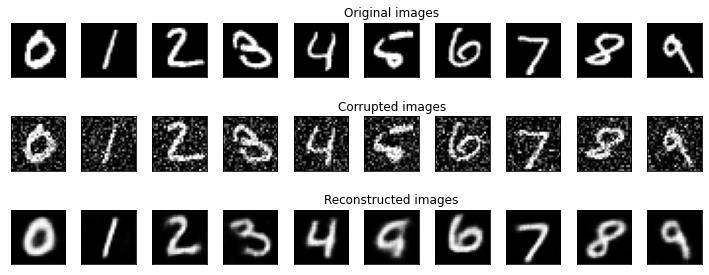

In [13]:
### Training cycle
noise_factor=0.3
nb_epochs=31
visu_freq=10
history_da={'train_loss':[],'test_loss':[]}

for epoch in range(nb_epochs):
    print('EPOCH %d/%d' % (epoch+1,nb_epochs))
    train_loss=train_epoch_den(
        encoder=encoder,
        decoder=decoder,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim,noise_factor=noise_factor)
    test_loss=test_epoch_den(
        encoder=encoder,
        decoder=decoder,
        dataloader=test_loader,
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['test_loss'].append(test_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t test loss {:.3f}'.format(epoch+1,nb_epochs,train_loss,test_loss))
    if epoch%visu_freq==0:
        plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

In [ ]:
#save the network
torch.save(encoder,"encoder.pth")
torch.save(decoder,"decoder.pth")

In [ ]:
#plot the loss evolution
plt.plot(list(range(nb_epochs)),history_da['train_loss'],label="train loss")
plt.plot(list(range(nb_epochs)),history_da['test_loss'],label="test loss")
plt.legend()
plt.show()

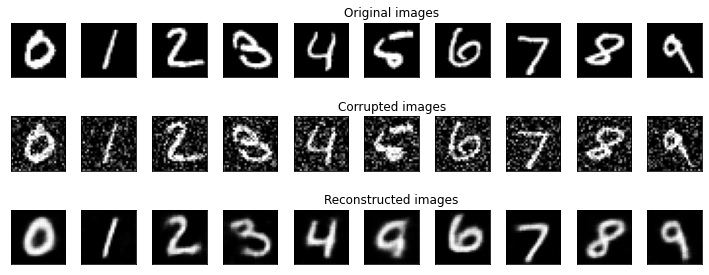

In [14]:
plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

tensor([-0.0925,  0.1977,  0.0821, -0.0311])
tensor([0.4722, 0.5486, 0.7941, 0.6437])


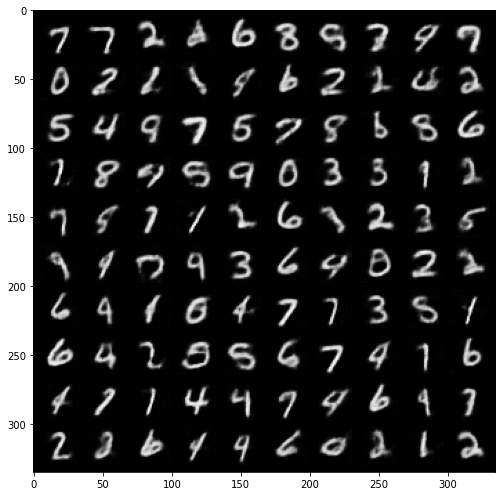

In [16]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code,generated takining in test images as inputs 
    images,labels=iter(test_loader).next()
    latent=encoder(images)

    mean=latent.mean(dim=0)
    print(mean)
    std=(latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent=torch.randn(128,d)*std + mean

    # reconstruct images from the random latent vectors
    img_recon=decoder(latent)

    fig,ax=plt.subplots(figsize=(20,8.5))
    npimg=torchvision.utils.make_grid(img_recon[:100],10,5).numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()